<a href="https://colab.research.google.com/github/lucas-fpaiva/matopiba_emissions/blob/main/code/groups.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perfil de emissões do matopiba

In [1]:
#analisis
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import bartlett


#visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from pandas.plotting import radviz
import matplotlib.gridspec as gridspec

#data inputation
from sklearn.impute import KNNImputer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

## Database 

In [2]:
!git clone https://github.com/lucas-fpaiva/matopiba_emissions.git

Cloning into 'matopiba_emissions'...
remote: Enumerating objects: 148, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 148 (delta 14), reused 1 (delta 1), pack-reused 121
Receiving objects: 100% (148/148), 10.03 MiB | 16.10 MiB/s, done.
Resolving deltas: 100% (57/57), done.


### Data cleaning

In [3]:
df = pd.read_csv('/content/matopiba_emissions/data/data.csv',
              error_bad_lines=False, encoding='utf-8',sep=';')
df['emi_energy_2018']=pd.to_numeric(df['emi_energy_2018'],errors='coerce')


data=df[['States', 'Municipalities', 'emi_2018', 'emi_agri_2018', 
       'emi_luc_2018', 'emi_energy_2018', 'emi_waste_2018', 
        'pib_2018']]

data['population'] = 1000*df['pib_2018']/df['pib_percapta_2018']
data['population'] = data['population'].astype(int)
data.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  #

,States,Municipalities,emi_2018,emi_agri_2018,emi_luc_2018,emi_energy_2018,emi_waste_2018,pib_2018,population
0,TO,Abreulândia,415469.12,127828.13,286357,530.51,753.48,52402.19,2564
1,MA,Açailândia,2012738.16,701929.89,1033654,221796.36,55357.90,2602790.66,111757
2,MA,Afonso Cunha,77780.74,7322.15,59017,10089.06,1352.53,50235.77,6468
3,MA,Água Doce do Maranhão,28598.69,6986.73,15176,3941.72,2494.25,86186.06,12488
4,TO,Aguiarnópolis,116760.47,20766.03,31678,62457.73,1858.71,124903.42,6571


### Data inputation

In [4]:
data_na=data[['pib_2018','population','emi_agri_2018', 
       'emi_luc_2018', 'emi_waste_2018', 
         'emi_energy_2018']]

input_method= 'Iterative'

if input_method== 'KNN':
  imputer = KNNImputer()
  

elif input_method== 'Iterative':
  imputer = IterativeImputer(max_iter=10, random_state=0)

df_input=imputer.fit_transform(data_na)

data['emi_energy_2018']= df_input[:,-1]

data['emi_2018'] = data['emi_agri_2018'] + data[ 'emi_luc_2018'] + data['emi_waste_2018'] +data['emi_energy_2018'] 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Feature engineering


In [5]:
def features_func(data_l):
    
    emi_2018 = ['emi_2018', 'emi_agri_2018', 'emi_luc_2018', 'emi_energy_2018', 'emi_waste_2018']
    
    
    j=0
    for i in emi_2018[1:]:
        data_l[features[j]] = data_l[i]/data_l[emi_2018[0]]
        j+=1

    return data_l

In [6]:
features=["Agriculture","LUC","Energy","Waste"]
features_group=["Agriculture","LUC","Energy","Waste","group"]
data_proces = features_func(data)
data_proces.columns

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Index(['States', 'Municipalities', 'emi_2018', 'emi_agri_2018', 'emi_luc_2018',
       'emi_energy_2018', 'emi_waste_2018', 'pib_2018', 'population',
       'Agriculture', 'LUC', 'Energy', 'Waste'],
      dtype='object')

## Identified groups

In [7]:
def number_of_clusters(wcss,interval):
    x1, y1 = interval[0], wcss[0]
    x2, y2 = interval[1], wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2


def silhouette_plot_(X,range_n,lim):
  nome = list(X.columns)

  kmeans_per_k = [KMeans(k,init = "k-means++", n_init=50, random_state=0).fit(X)
                for k in range(1, lim)]
  inertias = [model.inertia_ for model in kmeans_per_k]

  k_opt = number_of_clusters(inertias,[1,lim])
  fig = plt.figure(figsize = (8, 6), dpi = 300)
  gs = gridspec.GridSpec(11, 3)
  ax = fig.add_subplot(gs[0:4, :])
  ax.plot(range(2,lim+1), inertias, "bo-")
  ks = [k_opt-1,k_opt,k_opt+1]

  ax.plot(ks,inertias[k_opt-3:k_opt],"ro-",linewidth=2, markersize=12)

  ax.set_ylabel("WCSS", fontsize=fontsize)
  ax.set_xlabel("Groups \n", fontsize=fontsize)
  ax.grid(True)
  ax.annotate('Elbow',
             xy=(k_opt, inertias[k_opt]+0.5),
             xytext=(0.3, 0.85),
             textcoords='figure fraction',
             fontsize=fontsize,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )

  j=0
   
  ax.text(-0.15/3, 1.1, 'a', transform=ax.transAxes, 
            size=22, weight='bold')
    
    
  for n_clusters in range_n:
    
    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 0 for reproducibility.
    clusterer = KMeans(n_clusters = n_clusters, init = "k-means++", n_init=50, random_state=0)
    cluster_labels = clusterer.fit_predict(X)

    if n_clusters==k_opt:
      global model_top
      global labels 
      labels = cluster_labels
      model_top = clusterer

    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 20

    ax = fig.add_subplot(gs[6:11, j])
    ax.grid(True)
    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([0,  0.4,  0.8])
    ax.plot(np.arange(1., 0., -0.1) * 2000., np.arange(1., 0., -0.1))
    
    
    for i in range(n_clusters-1,-1,-1):
      # Aggregate the silhouette scores for samples belonging to
      # cluster i, and sort them      
      ith_cluster_silhouette_values = \
          sample_silhouette_values[cluster_labels == i]

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i
      
      # color = cm.nipy_spectral(float(i)*1.1 / n_clusters)
      # if n_clusters==k_opt:
      color = correct_color[i]
      ax.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=1)

      # Label the silhouette plots with their cluster numbers at the middle
      ax.text(-0.07, y_lower-20 + 0.5 * size_cluster_i, str(i+1))

      # Compute the new y_lower for next plot
      y_lower = y_upper + 20  # 10 for the 0 samples
    
      ax.set_title("\nk = "+str(n_clusters),fontsize=fontsize)
    if j==1:
      ax.set_xlabel("Silhouette score", fontsize=fontsize)
    if j==0:
        ax.set_ylabel("Groups \n", fontsize=fontsize)
        ax.text(-0.15, 1.05, 'b', transform=ax.transAxes, 
            size=22, weight='bold')
    j+=1
    # The vertical line for average silhouette score of all the values
    ax.set_xlim([-0.2, 1])
      # The (n_clusters+1)*10 is for inserting blank space between silhouette
      # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, X.shape[0] + (n_clusters + 1) * 20])
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
  plt.savefig("/content/matopiba_emissions/output/figure1.pdf", format="pdf", dpi=1000)
  plt.show()

In [8]:
correct_color = [(0.3764705882352941, 0.3764705882352941, 0.3764705882352941, 1),
                 (0, 0, 0.6470588235294118, 1),
                 (0, 0.6666666666666666, 0.6274509803921569, 1),
                 (0, 0.9764705882352941, 0, 1),
                 (0.8431372549019608, 0, 0, 1),
                 (1.0, 0.807843137254902, 0.0392156862745098, 1),
                 (0.1, 0.1, 0.1, 1)]

For n_clusters = 5 The average silhouette_score is : 0.41566612932554486
For n_clusters = 6 The average silhouette_score is : 0.4236165889252759
For n_clusters = 7 The average silhouette_score is : 0.40814237991418767


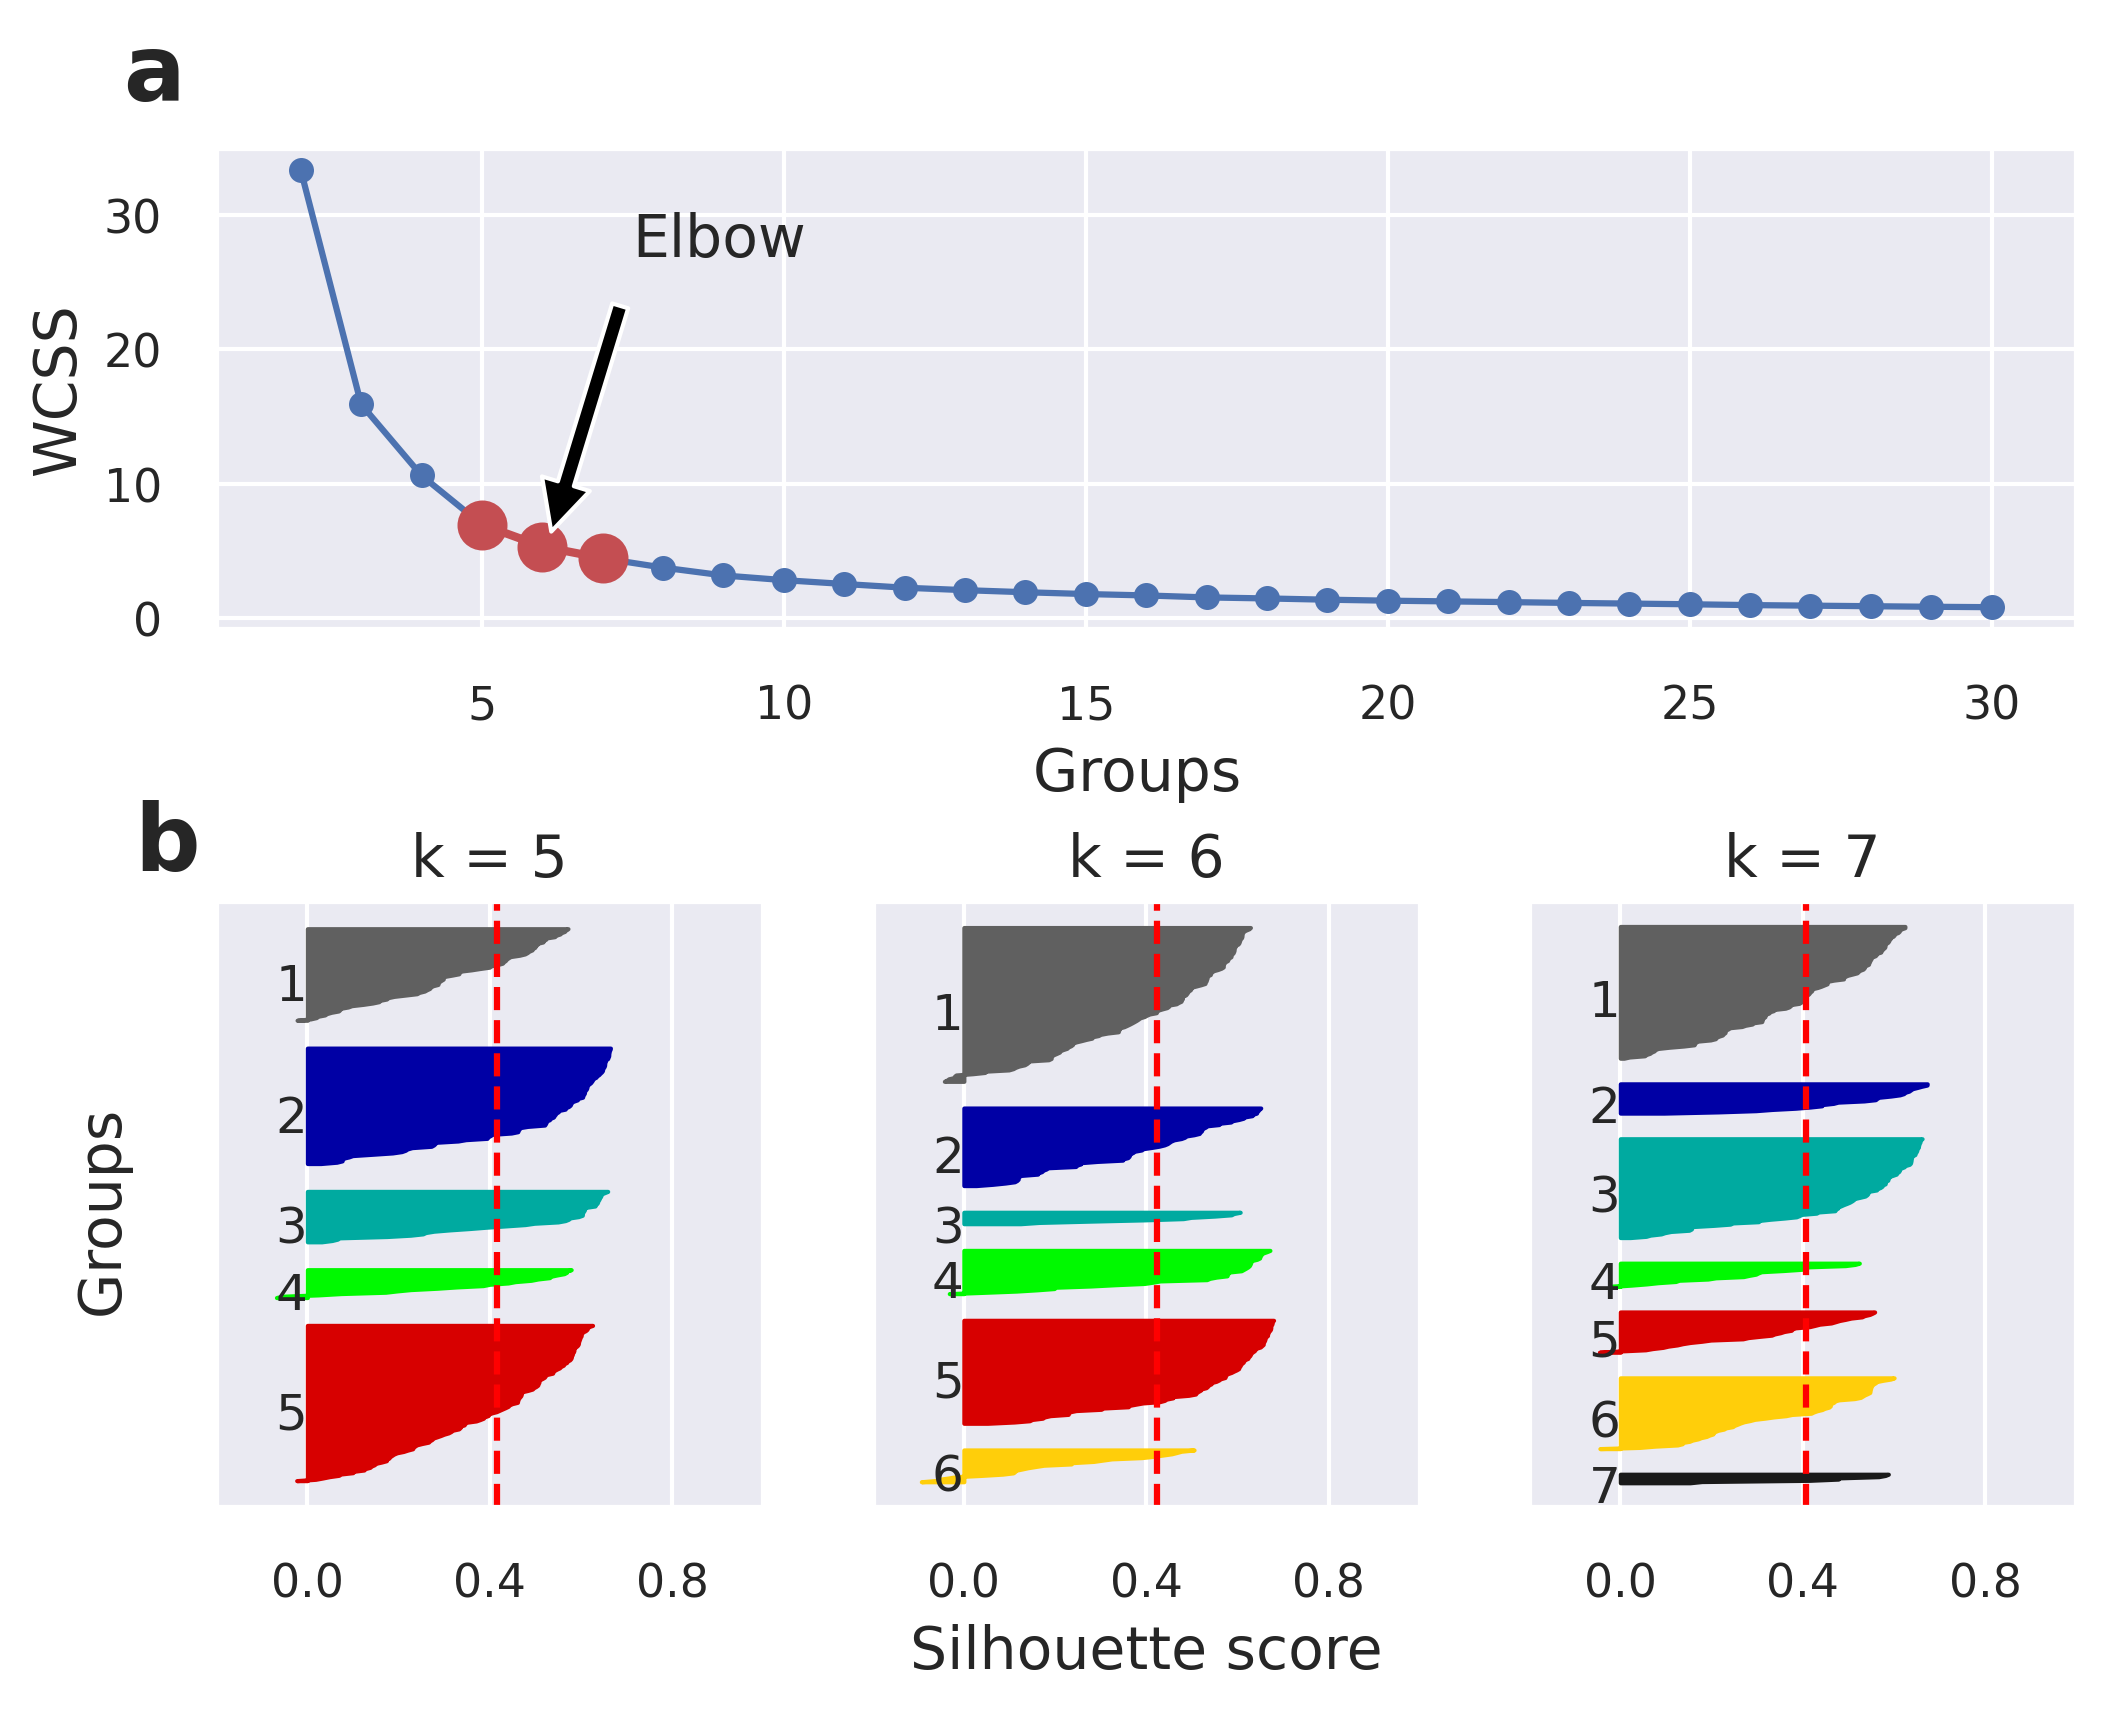

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

,States,Municipalities,emi_2018,emi_agri_2018,emi_luc_2018,emi_energy_2018,emi_waste_2018,pib_2018,population,Agriculture,LUC,Energy,Waste,group,group_name
0,TO,Abreulândia,415469.12,127828.13,286357,530.51,753.48,52402.19,2564,0.307672,0.689238,0.001277,0.001814,1,G1
1,MA,Açailândia,2012738.15,701929.89,1033654,221796.36,55357.90,2602790.66,111757,0.348744,0.513556,0.110196,0.027504,1,G1
2,MA,Afonso Cunha,77780.74,7322.15,59017,10089.06,1352.53,50235.77,6468,0.094138,0.758761,0.129712,0.017389,5,G5
3,MA,Água Doce do Maranhão,28598.70,6986.73,15176,3941.72,2494.25,86186.06,12488,0.244302,0.530653,0.137829,0.087216,1,G1
4,TO,Aguiarnópolis,116760.47,20766.03,31678,62457.73,1858.71,124903.42,6571,0.177852,0.271308,0.534922,0.015919,3,G3


In [9]:
fontsize = 14
menork = 5 
maiork = 7
range_n = range(menork,maiork+1)
lim = 30
sns.set_theme()
sns.set(font_scale = 1)
silhouette_plot_(data_proces[features],range_n,lim)
data['group'] = model_top.predict(data_proces[features])


data.to_csv('/content/matopiba_emissions/output/matopiba_groups.csv')
data.group = data.group+1
lista = []
for g in data.group:
    lista.append(str("G"+str(g)))


data['group_name'] = lista
data.head()

## Groups presentation

In [10]:
l=range(1,max(data.group)+1)

count=0

grupos =[]

ps_all = []

parametric = True
for coluna in features:
    count+=1
    k=0

    ps=[]
    met = []
    for i in l:
        k+=1
        for j in l[k:]:
            ''' Verificando se pode usar teste parametrico'''
            
            cat1 = data[data['group']==i]
            cat2 = data[data['group']==j]
            
            #Verificando o tamanho das amostras
            if min(len(cat1[coluna]),len(cat2[coluna]))>20:
                parametric = True
            else: parametric = False
            
            #verificando normalidade
            if parametric:
                _, p_1 = stats.normaltest(cat1[coluna])
                if p_1>=0.05:
                    # print(str('Normal ' + str(i)+ ' p ='), p_1)
                    parametric = True

                else: parametric = False
            
            if parametric:
                _, p_2 = stats.normaltest(cat2[coluna])
                if p_2>=0.05:
                    parametric = True
                else: parametric = False
            
            #Verificando Homocedasticidade
            if parametric:
                _, p_v = bartlett(cat1[coluna], cat2[coluna])
                if p_v>=0.05:
                    parametric = False
                
                
            # teste de diferenças
            if parametric:
                _,p=ttest_ind(cat1[coluna], cat2[coluna])
                if p<0.01:
                    met.append('t**')
                elif 0.01<p<0.05:
                    met.append('t*')
                else:
                    met.append('t')
                    print(coluna+str(i)+str(j))
                ps.append(p)
            else:
                _,p=mannwhitneyu(cat1[coluna], cat2[coluna])
                ps.append(p)
                if p<0.01:
                    met.append('U**')
                elif 0.01<p<0.05:
                    met.append('U*')
                else:
                    met.append('U')
                    print(coluna+' '+str(i)+'_'+str(j))
     
            if count==1:
                grupos.append(str(str(i)+'_'+str(j)))
            
    if count==1:
        ps_all.append(grupos)
            
    ps_all.append(ps)
    ps_all.append(met)



Agriculture 3_5
LUC 3_4
Energy 1_2
Energy 1_4
Energy 2_4
Waste 1_2
Waste 3_4
Waste 3_6


In [11]:
ps_all = np.array(ps_all).transpose()
dif = pd.DataFrame(ps_all,columns=['Comparison',"Agriculture",'Test',"LUC",'Test',"Energy",'Test','Waste','Test'])
dif.to_csv('/content/matopiba_emissions/output/statistic.csv')

dif.head(20)

,Comparison,Agriculture,Test,LUC,Test,Energy,Test,Waste,Test
0,1_2,1.2448431858010879e-28,U**,1.5907377961052222e-27,U**,0.23250153871649726,U,0.4854000254153665,U
1,1_3,3.955832643326857e-06,U**,7.962257393843353e-08,U**,7.962257393843353e-08,U**,0.020984042671875217,U*
2,1_4,1.1071057331383535e-19,U**,3.3875709613084095e-82,t**,0.05711890490958796,U,0.0003849402246884096,U**
3,1_5,4.689563270528249e-29,U**,4.4362557022662573e-32,U**,0.04283780228016201,U*,0.009695830114913267,U**
4,1_6,0.03621960770603322,U*,2.982283710008492e-44,t**,8.163318947786204e-15,U**,5.5289197156789206e-08,U**
5,2_3,2.3328212823671318e-07,U**,2.7641012166317565e-07,U**,2.3328212823671318e-07,U**,0.0268325047466269,U*
6,2_4,1.5891175328256985e-15,U**,4.719623111214117e-16,U**,0.17873325369050164,U,0.0010224924593972662,U**
7,2_5,5.676353777659301e-25,U**,5.676353777659301e-25,U**,0.013037291417984829,U*,0.01583936316950927,U*
8,2_6,4.3256594214999905e-11,U**,0.00014379021445242384,U**,2.7705926343397613e-13,U**,1.000286388022296e-07,U**
9,3_4,9.48892142100752e-07,U**,0.2517881963497022,U,9.48892142100752e-07,U**,0.2346940383948135,U


In [12]:
grupos = []
estados = ['MA','TO', 'PI','BA']
for i in range(1,7):
    linha =[]
    grupo = data[data['group']==i]
    count_grupo=grupo.shape[0]
    linha.append('G' +str(i))
    for est in estados:
        linha.append(round(100*len(grupo[grupo['States'] == est])/count_grupo,2))
    
    grupos.append(linha)
tab2 = pd.DataFrame(grupos,columns=['Group','MA','TO','PI','BA'])
tab2.head(7)

,Group,MA,TO,PI,BA
0,G1,45.08,40.16,9.02,5.74
1,G2,30.65,61.29,6.45,1.61
2,G3,40.00,50.00,0.00,10.00
3,G4,8.57,42.86,11.43,37.14
4,G5,54.88,24.39,14.63,6.10
5,G6,34.62,46.15,7.69,11.54


In [13]:
data.groupby(by='States')['Municipalities'].count().head()/337*100

States
BA     8.902077
MA    40.059347
PI     9.792285
TO    41.246291
Name: Municipalities, dtype: float64

MATOPIBA
Agriculture    35.48
LUC            54.25
Energy          7.53
Waste           2.74
dtype: float64

Group: 1
Agriculture    30.85
LUC            62.38
Energy          4.44
Waste           2.33
dtype: float64

Group: 2
Agriculture    51.07
LUC            42.48
Energy          4.34
Waste           2.11
dtype: float64

Group: 3
Agriculture    14.70
LUC            17.42
Energy         60.65
Waste           7.23
dtype: float64

Group: 4
Agriculture    75.18
LUC            15.63
Energy          5.66
Waste           3.53
dtype: float64

Group: 5
Agriculture    16.90
LUC            78.57
Energy          3.11
Waste           1.42
dtype: float64

Group: 6
Agriculture    33.16
LUC            33.66
Energy         25.70
Waste           7.47
dtype: float64



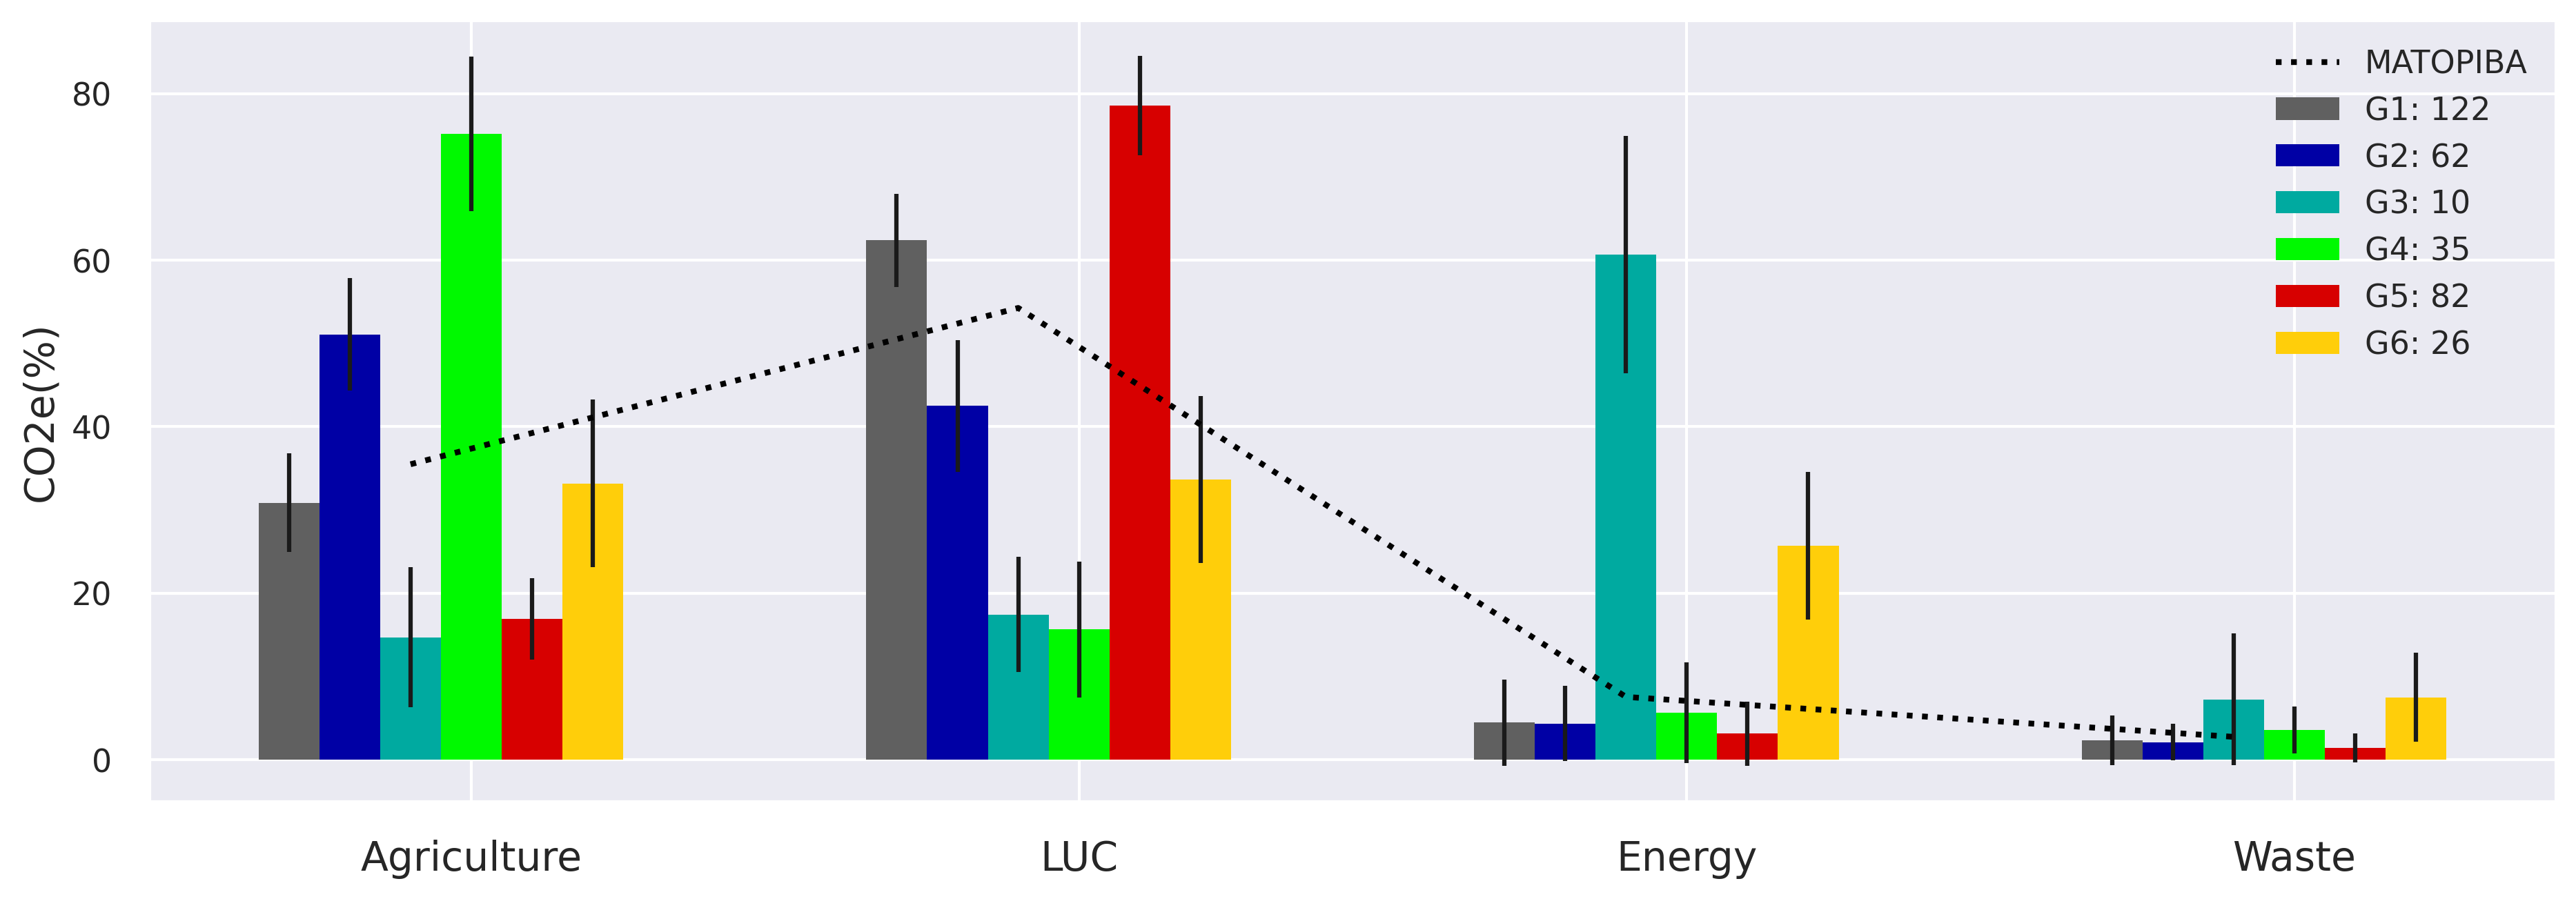

In [14]:
def bar_grupos(dados_sc,k):
  x = list(dados_sc.columns)[0:-1]
  
  fig = plt.figure(figsize = (15,5),dpi = 300)


  j=0
  
  print("MATOPIBA")
  print(round(dados_sc.drop(['group'],axis=1).mean()*100,2))
  print()
    

  barWidth = 0.1
  r = np.arange(4)
  r = [x-3*barWidth for x in r]
  for i in range(1,k+1):
    dado_g = dados_sc.loc[dados_sc['group']==i]
    dado_g = dado_g.drop(['group'],axis=1)
    dado_g = dado_g
    # color=(cm.nipy_spectral(float(i-1)*1.1 /k))
    color=correct_color[i-1]
    r = [x + barWidth for x in r]
    plt.bar(r, dado_g.mean()*100, width = barWidth, color = color, 
            edgecolor = 'white', lw=0.0, alpha=1, yerr=dado_g.std()*100, label=str('G'+str(i)+': '+str(dado_g.shape[0])))
    
    print("Group: "+str(i))
    print(round(dado_g.mean()*100,2))
    print()
    j+=1

  dado_g = dados_sc.drop(['group'],axis=1)
  r = [x-3*barWidth for x in r]
  plt.grid(True)
  plt.plot(r,dado_g.mean()*100,':',label=('MATOPIBA'), 
        linewidth=2,color = 'black') 

  plt.xticks([r + barWidth for r in range(len(dado_g.mean()))],x,fontsize=fontsize)
  plt.ylabel('CO2e(%)',fontsize=fontsize)
  plt.legend()
 
 
    
    
bar_grupos(data[features_group],max(data.group))

plt.savefig("/content/matopiba_emissions/output/figure2b.pdf", format="pdf", dpi=1000)

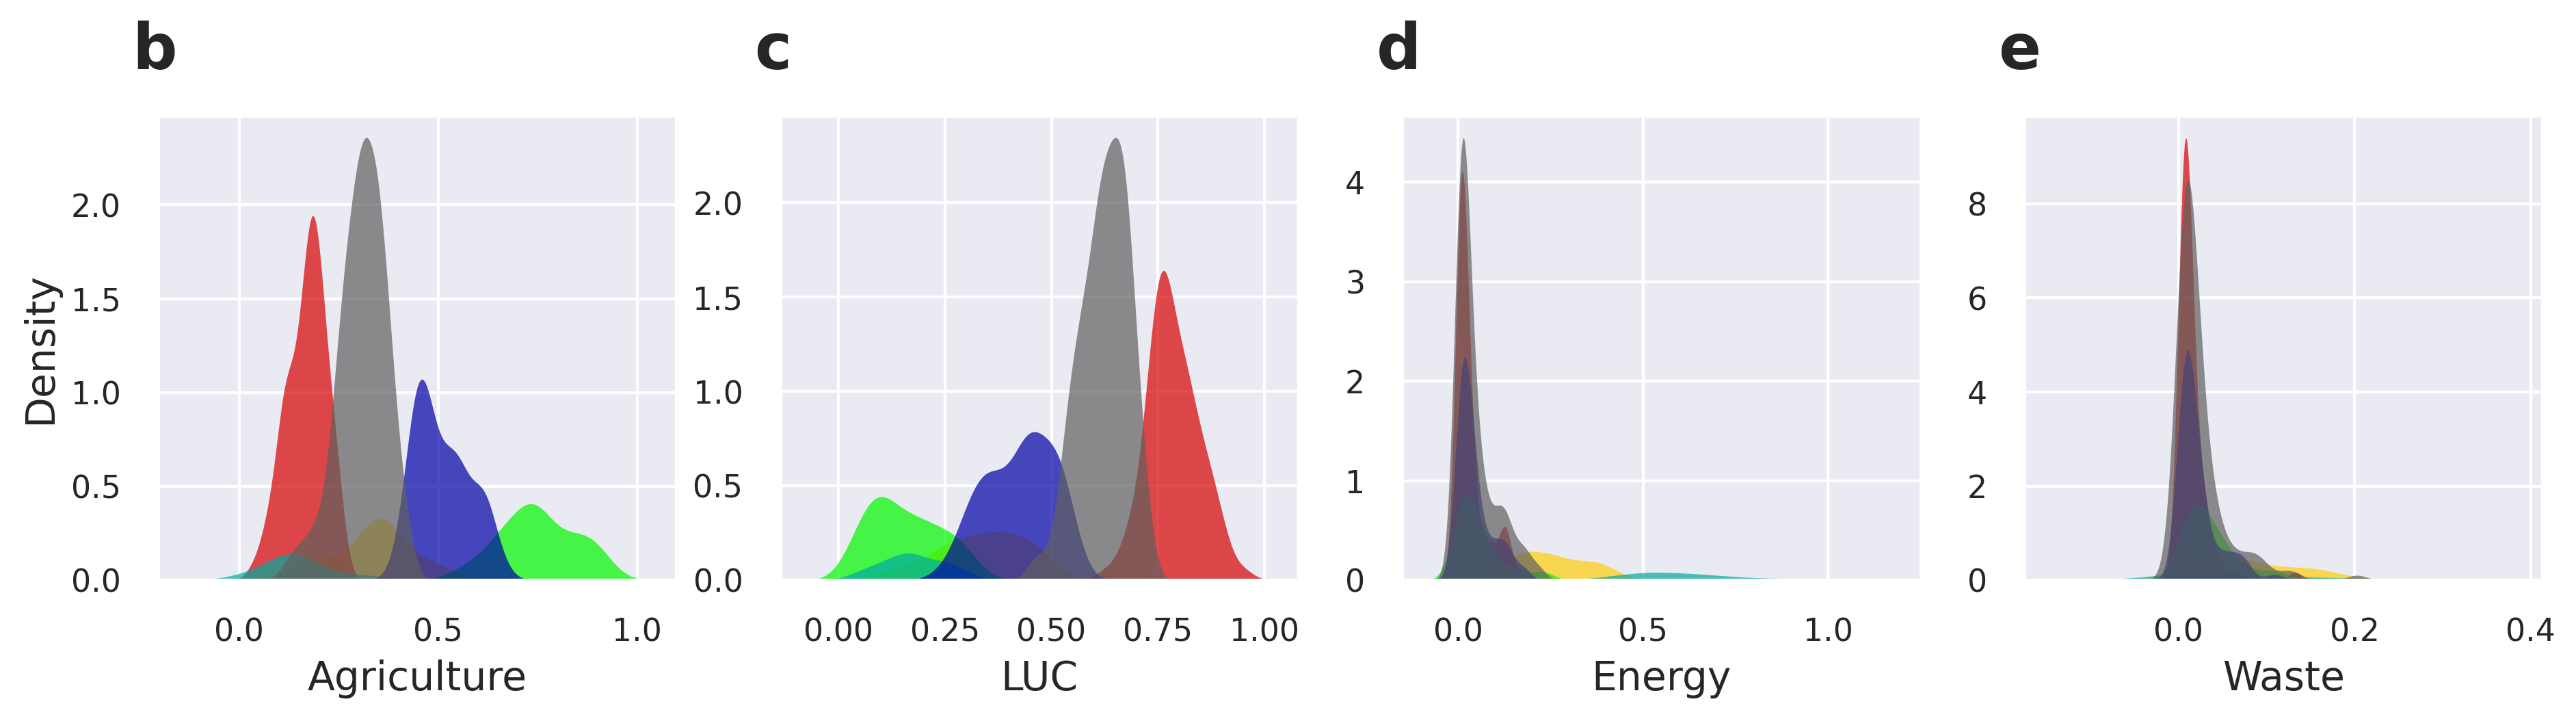

In [15]:
color = []
for i in range(1,k+1):
  color.append(cm.nipy_spectral(float(i-1)*1.1/k))

color=correct_color[0:-1]
fig = plt.figure(figsize = (15,3),dpi=300)

count=1
texto= ["b","c","d","e"]
for setor in features:

    plt.subplot(1,4,count)    
    ax=sns.kdeplot(data=data, x=setor, hue="group",palette=color ,fill=True,
   alpha=.7, linewidth=0,
)
    ax.text(-0.15/3, 1.1, texto[count-1], transform=ax.transAxes, 
            size=22, weight='bold')
    ax.set_xlabel(setor, fontsize=fontsize)
    if count ==1:
        ax.set_ylabel("Density", fontsize=fontsize)
        ax.legend_.set_title(None)
    else: 
        ax.set_ylabel(" ", fontsize=fontsize)
    count+=1
    ax.legend([],[], frameon=False)

plt.savefig("/content/matopiba_emissions/output/figure2a.pdf", format="pdf", dpi=1000)

##  Groups issuance profile

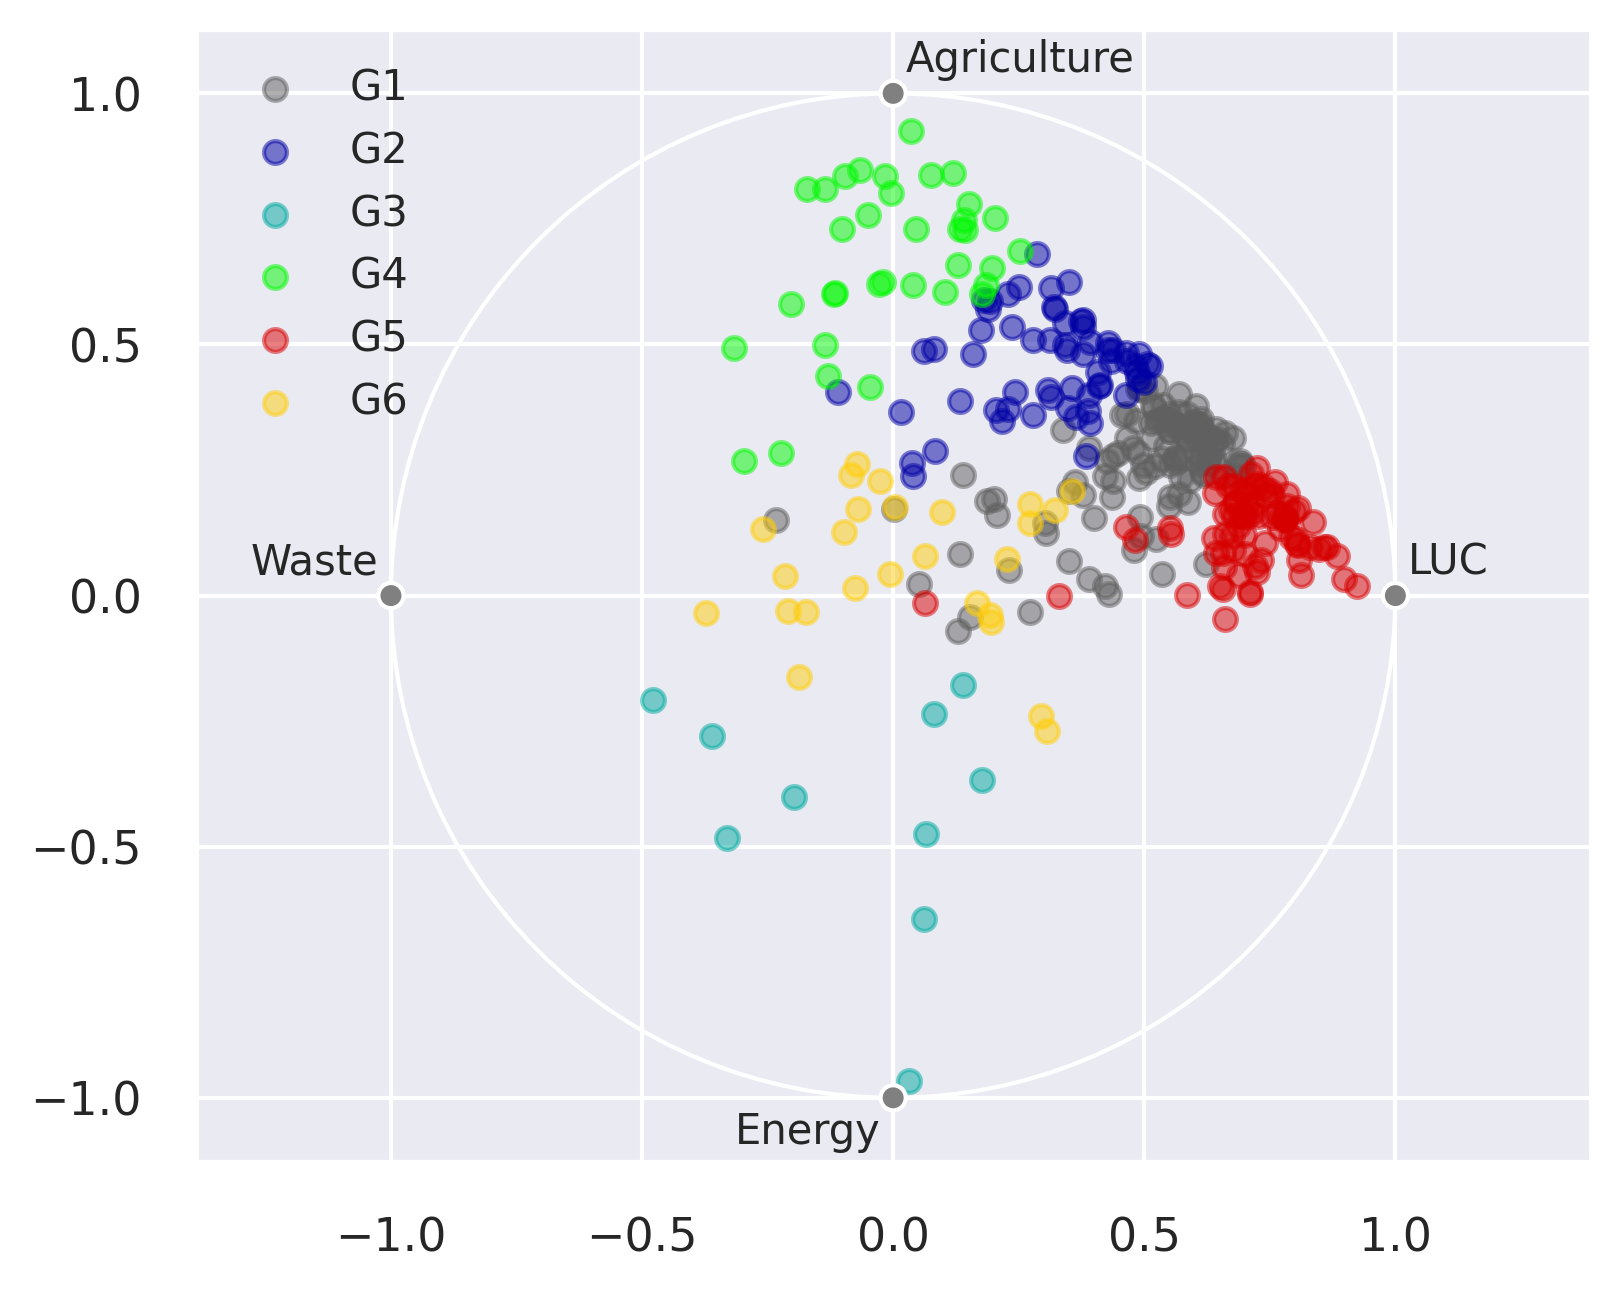

In [16]:
color=correct_color[0:-1]
fig = plt.figure(figsize = (6,5),dpi = 300)

radviz(data[["LUC","Agriculture","Waste","Energy","group_name"]].sort_values(by='group_name'),
       'group_name',color = color,alpha=0.5,s=30)
plt.legend(loc='upper left', ncol=1,fontsize=10)
plt.savefig("/content/matopiba_emissions/output/figure3.pdf", format="pdf", dpi=1000)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   States           337 non-null    object 
 1   Municipalities   337 non-null    object 
 2   emi_2018         337 non-null    float64
 3   emi_agri_2018    337 non-null    float64
 4   emi_luc_2018     337 non-null    int64  
 5   emi_energy_2018  337 non-null    float64
 6   emi_waste_2018   337 non-null    float64
 7   pib_2018         337 non-null    float64
 8   population       337 non-null    int64  
 9   Agriculture      337 non-null    float64
 10  LUC              337 non-null    float64
 11  Energy           337 non-null    float64
 12  Waste            337 non-null    float64
 13  group            337 non-null    int32  
 14  group_name       337 non-null    object 
dtypes: float64(9), int32(1), int64(2), object(3)
memory usage: 38.3+ KB


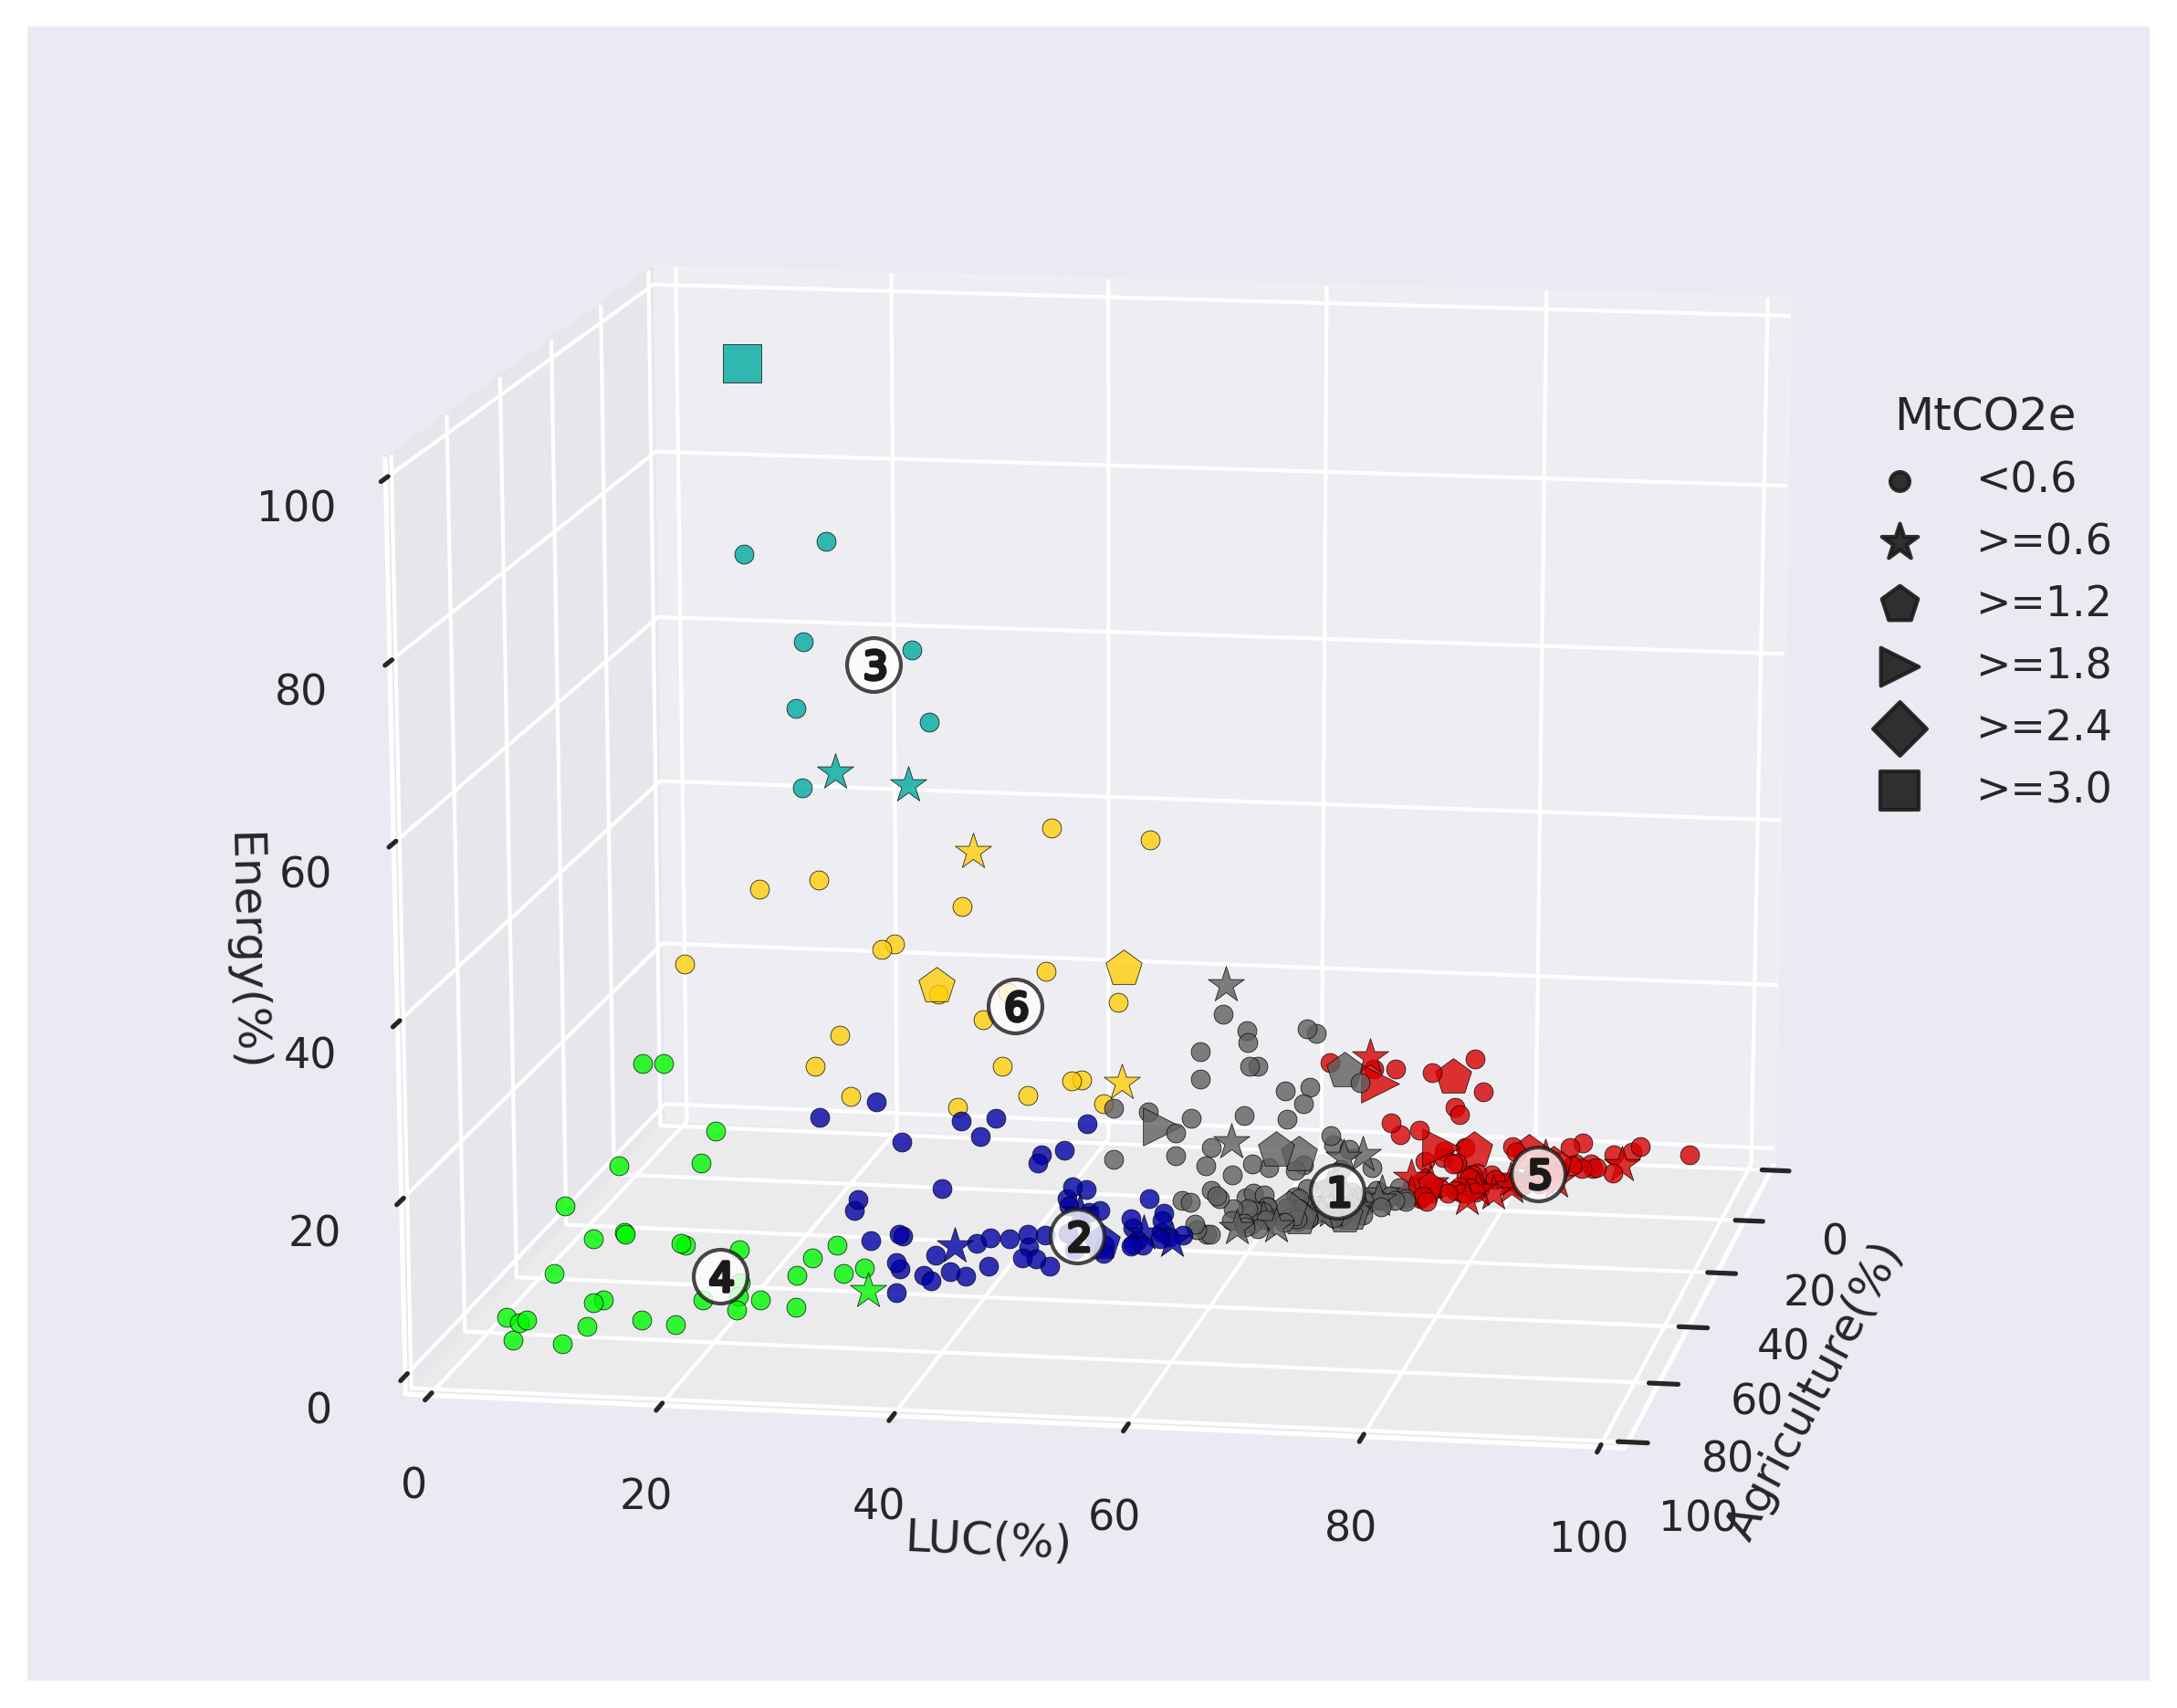

<Figure size 432x288 with 0 Axes>

In [18]:
from mpl_toolkits.mplot3d import Axes3D

# color = []
# for i in range(1,k+1):
#   color.append(cm.nipy_spectral(float(i-1)*1.1 /k))

fig = plt.figure(figsize = (10,8),dpi = 300)
ax = fig.add_subplot(111, projection='3d')


max_emi = max(data.emi_2018)
faixa = max_emi/5
markers = ['.','*','p','>','D','s']

for i in range(1,7):
  m=-1
  for j in data[data.group==i].emi_2018.values:
    m=m+1
    size = 10+int(j/max(data[data.group==i].emi_2018)*90)
    line=ax.scatter3D(data[data.group==i]['Agriculture'].values[m]*100,
                      data[data.group==i]['LUC'].values[m]*100, data[data.group==i]['Energy'].values[m]*100,
                      color=correct_color[i-1], s=100,edgecolor='black',
                      linewidth=0.2,marker=markers[int(j/faixa)],alpha=0.8)
    
ax.view_init(15,10)

lege=['<0.6','>=0.6','>=1.2','>=1.8','>=2.4','>=3.0']
le=0
for marker in markers:
  ax.scatter3D(-100,-100,-100, color=(0.1,0.1,0.1,1), alpha=0.9,s=100,marker=marker,label=lege[le])
  le=le+1



ax.set(xlim=(0, 100), ylim=(0, 100),zlim=(0, 100))
ax.set_zlabel('Energy(%) ',fontsize=fontsize-2)
ax.set_ylabel('LUC(%)', fontsize=fontsize-2)
ax.set_xlabel('Agriculture(%)', fontsize=fontsize-2)
ax.legend(title='MtCO2e',loc='best', bbox_to_anchor=(0.5, 0.3, 0.5, 0.5))



centers = model_top.cluster_centers_ 

# Draw white circles at cluster centers
grupos_count = data.groupby('group').count()
group_size = list(grupos_count['Municipalities'])

for i, c in enumerate(centers):
  color=correct_color[i-1]
  
  ax.scatter3D(c[0]*100+5, c[1]*100+5, c[2]*100, marker='o',
          c='white', alpha=.8, s=200, edgecolor='k') #*group_size[i]
  ax.scatter3D(c[0]*100+5, c[1]*100+5,c[2]*100, marker='$%d$' % int(i+1), alpha=1,
              s=60, edgecolor='k',c='k')#color
plt.show()
plt.savefig("/content/matopiba_emissions/output/figure4a3D.pdf", format="pdf", dpi=1000)

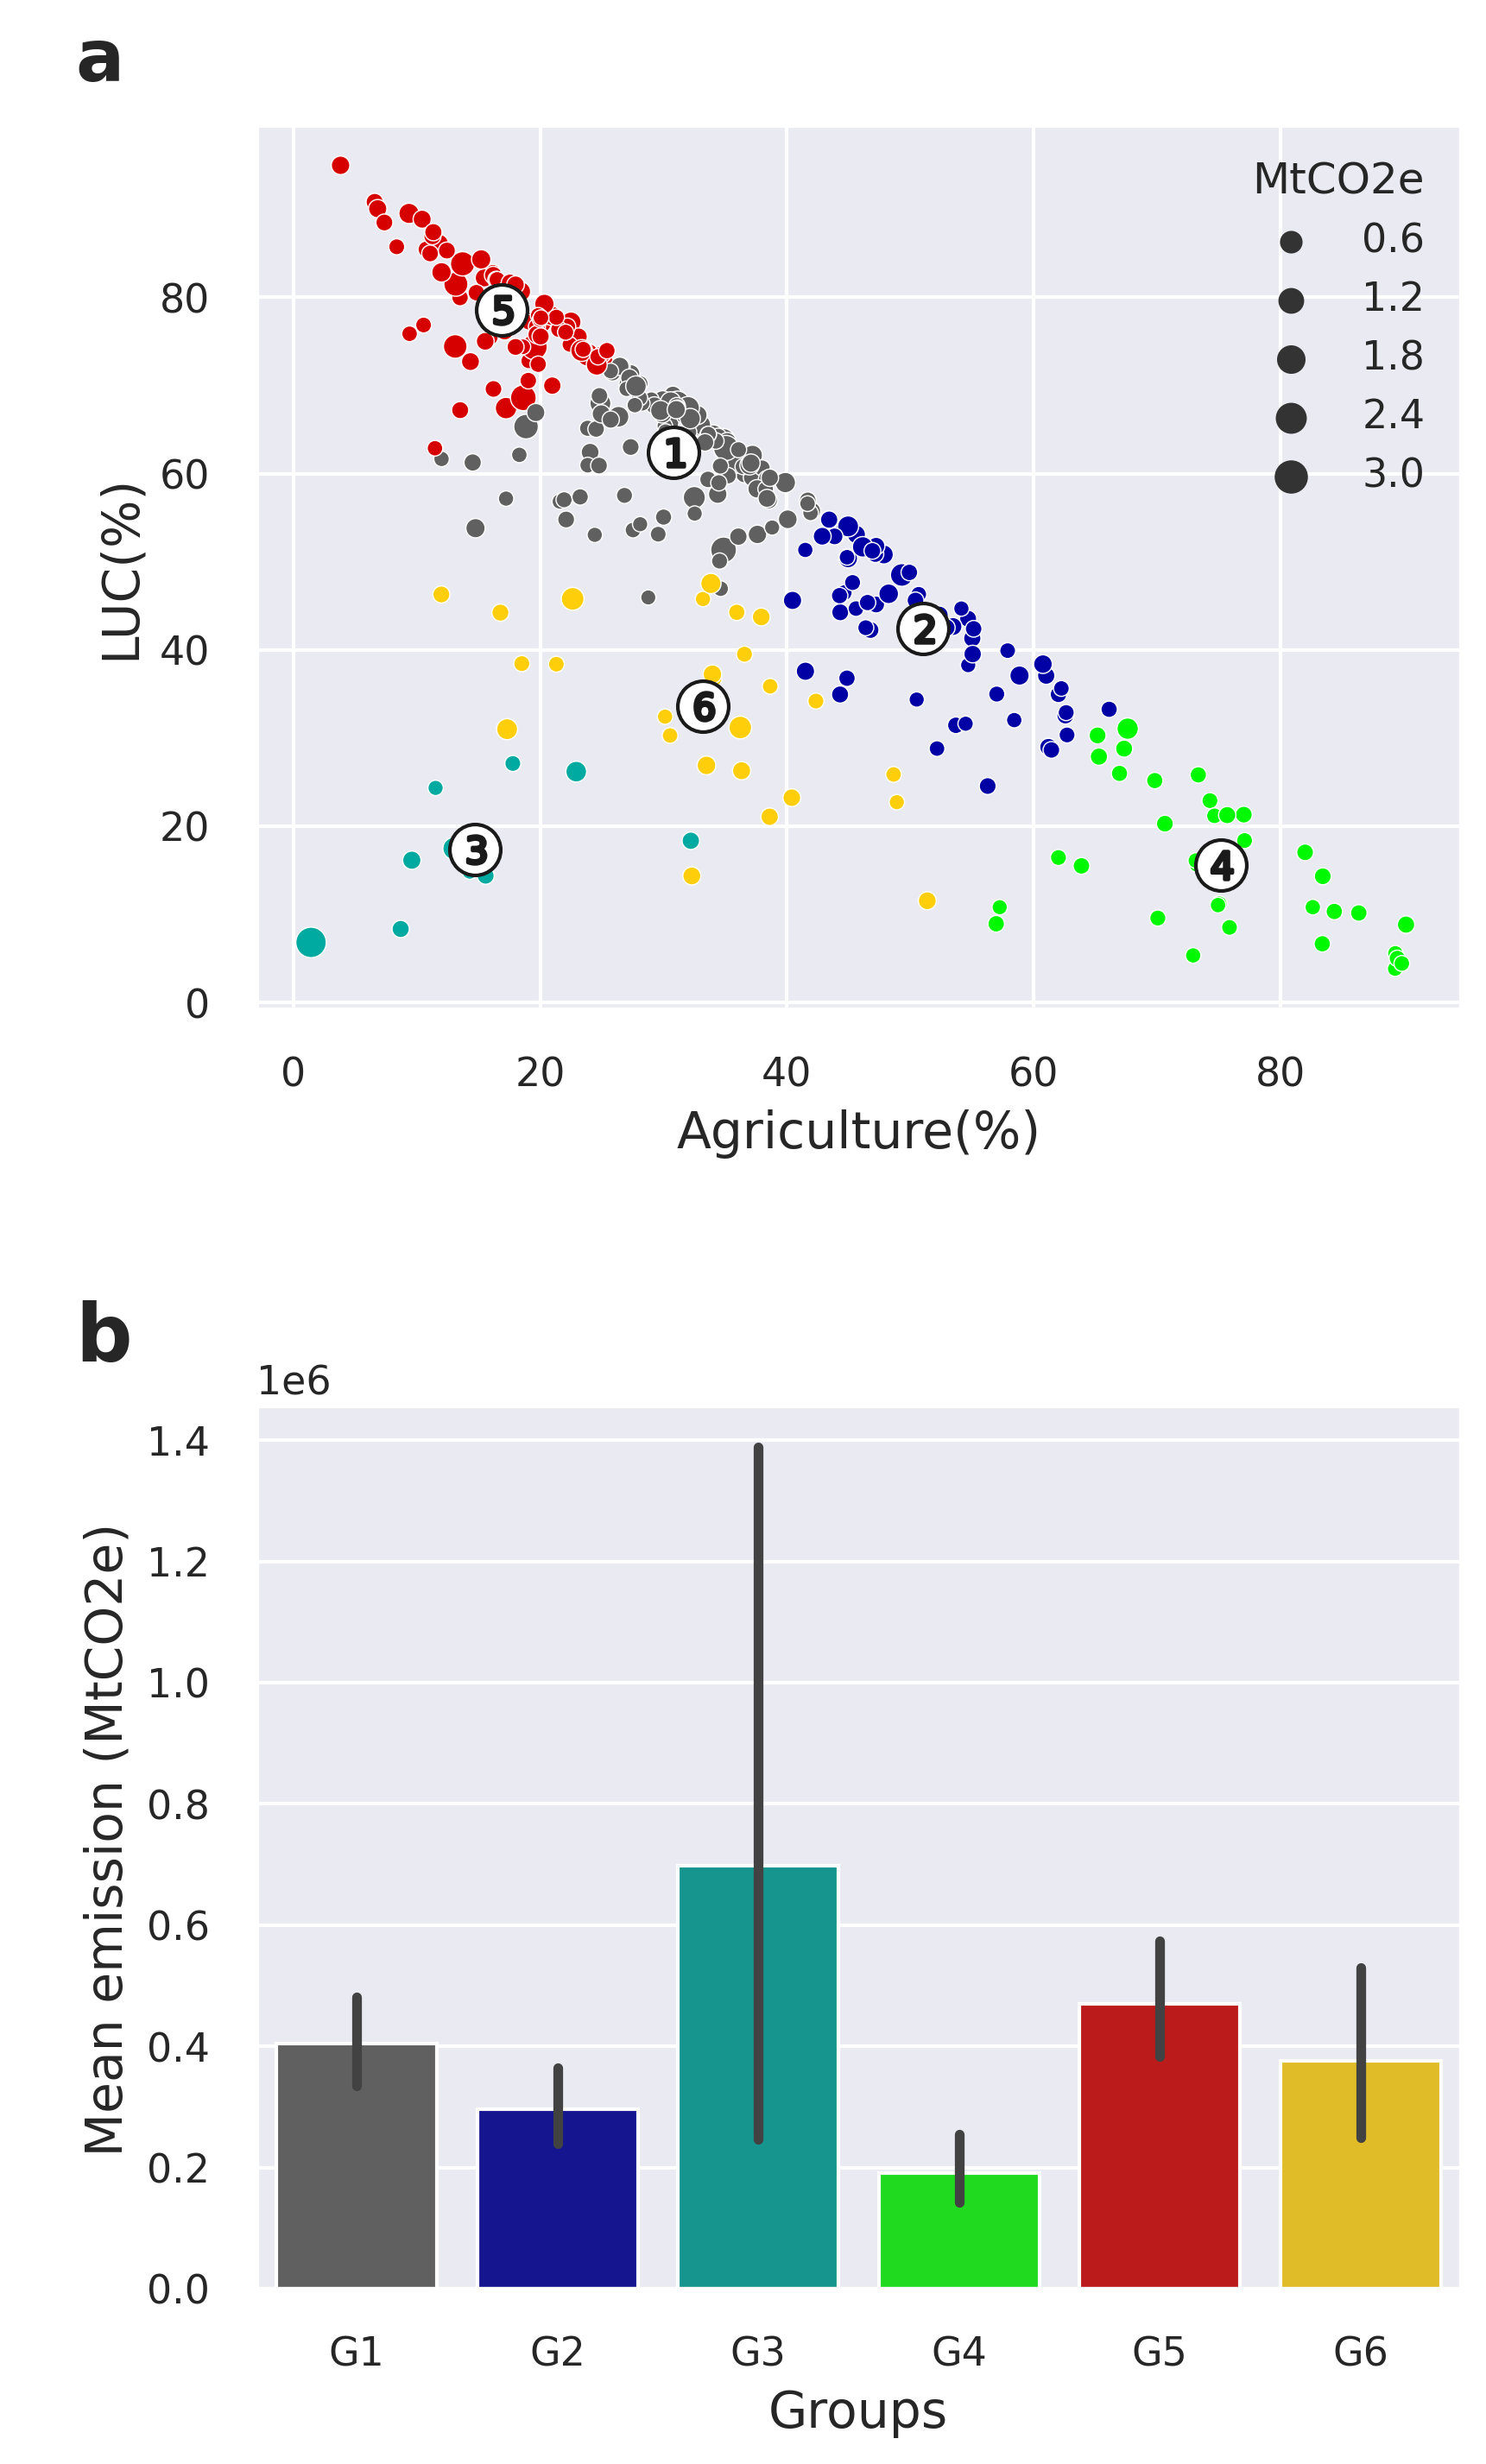

In [19]:
import matplotlib.gridspec as gridspec

fontsize=14
fig = plt.figure(figsize = (6,12),dpi = 300)
gs = gridspec.GridSpec(13, 1)

ax = fig.add_subplot(gs[0:5, 0])

n_clusters=k


color = correct_color[0:-1]


ax=sns.scatterplot(data=data*100 , x="Agriculture", y="LUC",  hue="group",legend = False,  alpha=1,
                   size ="emi_2018",s=5000, marker='o',  palette=color) 
ax=sns.scatterplot(data=data*100 , x="Agriculture", y="LUC", size ="emi_2018",alpha=0.0,
           palette=color) 
ax.set_ylabel('LUC(%)',fontsize=fontsize)
ax.set_xlabel('Agriculture(%)', fontsize=fontsize)
ax.text(-0.15, 1.05, 'a', transform=ax.transAxes, 
    size=20, weight='bold')
plt.legend(title='MtCO2e')



centers = model_top.cluster_centers_ 

# Draw white circles at cluster centers
grupos_count = data.groupby('group').count()
group_size = list(grupos_count['Municipalities'])

for i, c in enumerate(centers):
  color=correct_color[i]
  
  ax= plt.scatter(c[0]*100, c[1]*100, marker='o',
          c='white', alpha=1, s=200, edgecolor='k') #*group_size[i]
  ax=plt.scatter(c[0]*100, c[1]*100, marker='$%d$' % int(i+1), alpha=1,
              s=60, edgecolor='k',c='k')#color


ax = fig.add_subplot(gs[7:12, 0])    

ax = sns.barplot(x='group_name', y="emi_2018",alpha=1,
                      data=data.sort_values(by=['group']),palette=correct_color[0:-1])
ax.set_xlabel('Groups',fontsize=fontsize)
ax.set_ylabel('\n Mean emission (MtCO2e)', fontsize=fontsize)
ax.text(-0.15, 1.05, 'b', transform=ax.transAxes, 
    size=22, weight='bold')


plt.savefig("/content/matopiba_emissions/output/figure4.pdf", format="pdf", dpi=1000)

### Testing for the presence of correlations

In [20]:
_, p1 = stats.normaltest(data['Agriculture'])
_, p2 = stats.normaltest(data['LUC'])
print("Normality test: ",p1,p2)
data[["Agriculture", 'LUC']].corr()
## -0.783561

Normality test:  9.193029448768542e-09 4.426839940695092e-06


,Agriculture,LUC
Agriculture,1.000000,-0.762074
LUC,-0.762074,1.000000


In [21]:
#excluindo o grupo 3
_, p1 = stats.normaltest(data['Agriculture'][data.group !=3])
_, p2 = stats.normaltest(data['LUC'][data.group !=3])
print("Normality test: ",p1,p2)
data[["Agriculture", 'LUC']][data.group !=3].corr()
## -0.882981

Normality test:  1.5528110521754852e-08 2.464493684614261e-05


,Agriculture,LUC
Agriculture,1.000000,-0.880528
LUC,-0.880528,1.000000


In [22]:
#excluindo o grupo 6
_, p1 = stats.normaltest(data['Agriculture'][data.group !=3][data.group !=6])
_, p2 = stats.normaltest(data['LUC'][data.group !=3][data.group !=6])
print("Normality test: ",p1,p2)
data[["Agriculture", 'LUC']][data.group !=3][data.group !=6].corr()
## -0.954353

Normality test:  2.1975624471610154e-07 1.0727825091246361e-06


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,Agriculture,LUC
Agriculture,1.000000,-0.948818
LUC,-0.948818,1.000000


In [23]:
data[data.group==5].sort_values(by='emi_2018',ascending=False).head(5)

,States,Municipalities,emi_2018,emi_agri_2018,emi_luc_2018,emi_energy_2018,emi_waste_2018,pib_2018,population,Agriculture,LUC,Energy,Waste,group,group_name
94,BA,Correntina,1991731.83,371215.01,1366565,244717.75,9234.07,1944161.68,32081,0.186378,0.686119,0.122867,0.004636,5,G5
137,MA,Grajaú,1978841.31,386536.69,1471716,101171.49,19417.13,751654.33,68876,0.195335,0.743726,0.051127,0.009812,5,G5
150,MA,Itinga do Maranhão,1660611.19,227694.68,1391740,29303.10,11873.41,321167.19,25931,0.137115,0.838089,0.017646,0.007150,5,G5
83,MA,Codó,1616341.21,212846.61,1317333,47292.27,38869.33,963180.19,122597,0.131684,0.815009,0.029259,0.024048,5,G5
40,MA,Barra do Corda,1595140.78,272482.87,1228381,67637.99,26638.92,723386.24,87793,0.170821,0.770077,0.042403,0.016700,5,G5


# Spatial observation

In [24]:
df_graf= data[['States', 'Municipalities', 'emi_2018','group_name','group','pib_2018','population','Agriculture','LUC','Energy','Waste']]
df_graf['ID']=df_graf["Municipalities"]+df_graf['States']
df_graf.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,States,Municipalities,emi_2018,group_name,group,pib_2018,population,Agriculture,LUC,Energy,Waste,ID
0,TO,Abreulândia,415469.12,G1,1,52402.19,2564,0.307672,0.689238,0.001277,0.001814,AbreulândiaTO
1,MA,Açailândia,2012738.15,G1,1,2602790.66,111757,0.348744,0.513556,0.110196,0.027504,AçailândiaMA
2,MA,Afonso Cunha,77780.74,G5,5,50235.77,6468,0.094138,0.758761,0.129712,0.017389,Afonso CunhaMA
3,MA,Água Doce do Maranhão,28598.70,G1,1,86186.06,12488,0.244302,0.530653,0.137829,0.087216,Água Doce do MaranhãoMA
4,TO,Aguiarnópolis,116760.47,G3,3,124903.42,6571,0.177852,0.271308,0.534922,0.015919,AguiarnópolisTO


In [32]:
!git clone https://github.com/tbrugz/geodata-br.git

Cloning into 'geodata-br'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 82 (delta 12), reused 11 (delta 11), pack-reused 56
Unpacking objects: 100% (82/82), done.


In [25]:
df_loc = pd.read_csv('/content/matopiba_emissions/data/municipalities_loc.csv',error_bad_lines=False,encoding='latin-1')
df_loc = df_loc.loc[df_loc['codigo_uf'].isin([17,21,22,29])]
df_loc['codigo_uf'] = df_loc['codigo_uf'].map({17:'TO',
                             21:'MA',
                             22:'PI',
                             29:'BA'},
                             na_action=None)
df_loc.rename(columns={"nome":"CIDADES",'codigo_uf':'ESTADOS','latitude':'lat','longitude':'long'}, inplace=True)
df_loc['ID'] = df_loc["CIDADES"]+df_loc['ESTADOS']

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [26]:
df_graf=df_graf.merge(df_loc[['ID','lat','long']],on='ID')

No handles with labels found to put in legend.


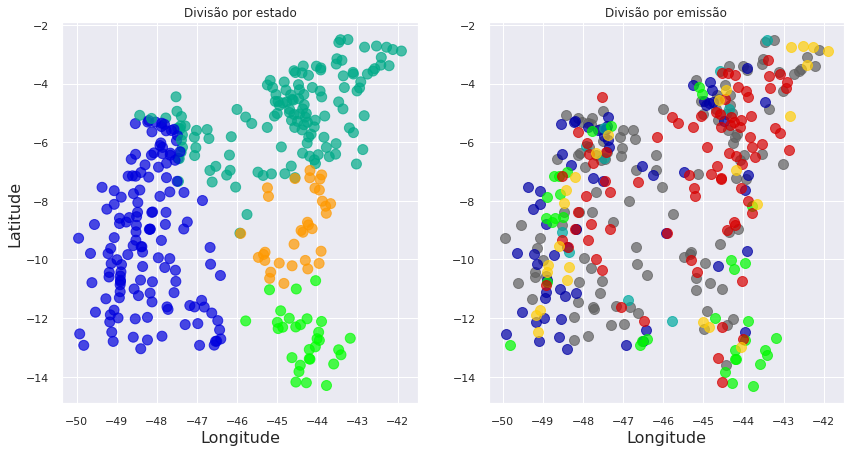

In [27]:
plt.figure(figsize=(14,7))
plt.subplot(121)

color = []
for j in df_graf["States"]:
  if j=="TO":
    i=1
  if j=="MA":
    i=2
  if j=="BA":
    i=3
  if j=="PI":
    i=4
  color.append(cm.nipy_spectral(float(i)/5))

plt.title("Divisão por estado")
plt.ylabel("Latitude",fontsize=16)
plt.scatter(df_graf["long"],df_graf["lat"], s=100, c=color, alpha=0.7) #, s=df_graf['emi_geral_2018']/10000
plt.xlabel("Longitude",fontsize=16)
# plt.ylabel("Latitude",fontsize=16)
plt.legend()



plt.subplot(122)
for i in range(1,7):
  color = correct_color[i-1]
  plt.scatter(df_graf[df_graf.group==i]["long"],df_graf[df_graf.group==i]["lat"], s=100,  color=color, alpha=0.7)#s=df_graf['emi_geral_2018']/10000,
plt.title("Divisão por emissão")
plt.xlabel("Longitude",fontsize=16)



plt.show()


In [28]:
df_graf.count()

States            337
Municipalities    337
emi_2018          337
group_name        337
group             337
pib_2018          337
population        337
Agriculture       337
LUC               337
Energy            337
Waste             337
ID                337
lat               337
long              337
dtype: int64

In [29]:
correct_html_color = ['#606060','#0000A5','#00AAA0','#00F900','#D70000','#FFCE0A']

In [30]:
import pandas as pd
import folium
map = folium.Map(location=[df_graf.lat.mean(), df_graf.long.mean()], zoom_start=5, control_scale=True)

for i in range(0,df_graf.shape[0]):

    color = correct_html_color[df_graf.group[i]-1]
    folium.CircleMarker([df_graf.lat[i],
                   df_graf.long[i]],
                       radius=5,
                color=color,
                fill=True,
                fill_color=color,
                popup=str('<i>' +df_graf.Municipalities[i]+ ':' +df_graf.group_name[i]+ '</i>')
                  ).add_to(map)

map

In [31]:
map.save('/content/map_matopiba.html')